# Homework 9

# I 推导ARCH(1)参数

\begin{aligned}
a_t &= \sigma_t \epsilon_t \\
\sigma_t^2 &= \alpha_0 + \alpha_1 a_{t-1}^2 \\ 
\end{aligned}

显然$\alpha_0 > 0$.

注意到(在弱平稳假设下)：
\begin{aligned}
Var(a_t) &= E(a_t^2) \\
&= E(\sigma_t^2 E(\epsilon_t^2|\mathcal F_{t-1})) \\
&= E(\sigma_t^2) \\
&= \alpha_0 + \alpha_1 E(a_{t-1}^2) \\
&= \alpha_0 + \alpha_1 Var(a_{t-1}) \\
\end{aligned}

即：$Var(a_t) = \frac{\alpha_0}{1-\alpha_1}$，由此推出$0 < \alpha_1 < 1$。


如果我们需要$a_t$具有四阶矩，且假设其严平稳：

\begin{aligned}
E(a_t^4) &= E[E(a_t^4 | \mathcal F_{t-1})] \\
&= E[E(\sigma_t^4 \epsilon_t^4 | \mathcal F_{t-1})] \\
&= 3 E(\sigma_t^4) \\
&= 3 E(\alpha_0 + \alpha_1 a_{t-1}^2)^2 \\
&= 3 E(\alpha_0^2 + 2 \alpha_0 \alpha_1 a_{t-1}^2 + \alpha_1^2 a_{t-1}^4) \\
&= 3 (\alpha_0^2 + 2 \alpha_0 \alpha_1 E(a_{t-1}^2) + \alpha_1^2 E(a_{t-1}^4)) \\
\end{aligned}

由此推出：

$$
(1 - 3\alpha_1^2) Ea_t^4 = 3(\alpha_0 + 2\alpha_0\alpha_1 \frac{\alpha_0}{1 - \alpha_1})
$$

由正负性易知$0 < \alpha_1 < \frac{1}{\sqrt{3}}$。

# II ARCH建模

In [145]:
import numpy as np
import pandas as pd

data = pd.read_excel('600519.SH.xlsx').set_index('日期').dropna()
returns = np.log(data['收盘价(元)'].pct_change()+1)['20230801':'20231001']

In [146]:
print("Mean: ", returns.mean().item())
print("Standard Deviation: ", returns.std().item())
print("Skewness: ", returns.skew().item())
print("Kurtosis: ", returns.kurtosis().item())

Mean:  -0.0010371966322837095
Standard Deviation:  0.010545668007833835
Skewness:  0.6962263715560497
Kurtosis:  1.5121456039728653


In [147]:
# DF-Test（调包）
from statsmodels.tsa.stattools import adfuller
result = adfuller(returns.values)
print("ADF Statistic: ", result[0])
print("p-value: ", result[1])
print("Critical Values: ", result[4])

# DF-Test（手动）
from scipy.stats import t
y = returns.values[1:].copy()
x = returns.values[:-1].copy()
phi = np.sum(x*y) / np.sum(x**2)
sigma_2 = np.sum((y-phi*x)**2) / (len(y)-1)
df = (phi - 1) / np.sqrt(sigma_2 / np.sum(x**2))

print("由此知道该时间序列不存在单位根")


ADF Statistic:  -7.084042444124269
p-value:  4.587347221267072e-10
Critical Values:  {'1%': -3.596635636000432, '5%': -2.933297331821618, '10%': -2.6049909750566895}
由此知道该时间序列不存在单位根


In [148]:
# 均值模型
residual = returns - returns.mean()

In [149]:
# Q* Ljung-Box检验
def _gamma(X, n):
    x_1 = X; x_2 =  np.append([0] * n, X[:len(X)-n])
    mu = np.mean(X)
    return np.mean((x_1 - mu) * (x_2 - mu)) / np.var(X)

def QLB_test(residual, lag=5):
    from scipy.stats import chi2
    n = len(residual)
    gamma_noise = np.array([])
    for k in range(1, lag+1):
        gamma_noise = np.append(gamma_noise, _gamma(residual, k))

    alpha = 0.05
    p = chi2.ppf(1-alpha, lag)
    coef = np.array([1/(n-k) for k in range(1, lag+1)])
    QLB = n * (n + 2) * np.sum(coef * gamma_noise**2)

    print("Q* Ljung-Box检验的统计量为：", QLB)
    print("Q* Ljung-Box检验的p值为：", p)
    if QLB > p:
        print("由于统计量大于p值，所以拒绝原假设，即残差不是白噪声")
    else:
        print("由于统计量小于p值，所以不能拒绝原假设，即残差是白噪声")
QLB_test(residual)

Q* Ljung-Box检验的统计量为： 1.224412299021933
Q* Ljung-Box检验的p值为： 11.070497693516351
由于统计量小于p值，所以不能拒绝原假设，即残差是白噪声


In [150]:
# 平方序列
QLB_test(residual**2)

Q* Ljung-Box检验的统计量为： 7.998332585190402
Q* Ljung-Box检验的p值为： 11.070497693516351
由于统计量小于p值，所以不能拒绝原假设，即残差是白噪声


In [151]:
# 绝对值序列
QLB_test(np.abs(residual))

Q* Ljung-Box检验的统计量为： 13.032715380760663
Q* Ljung-Box检验的p值为： 11.070497693516351
由于统计量大于p值，所以拒绝原假设，即残差不是白噪声


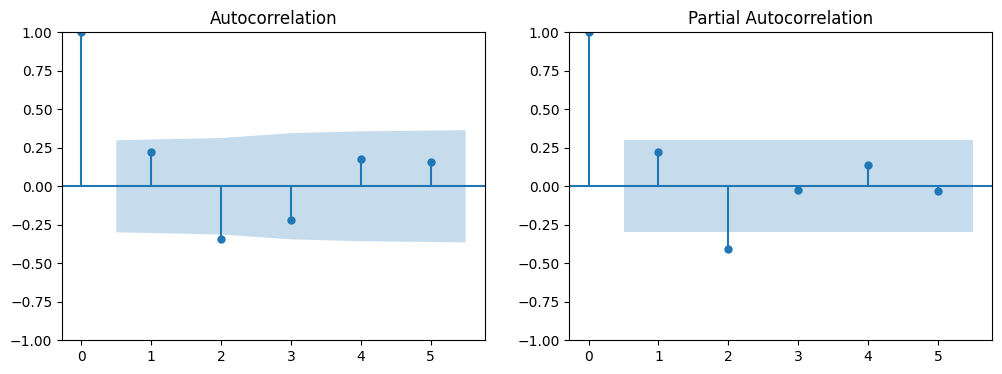

In [152]:
# 考虑ARCH模型
ts = np.abs(returns)
def acf_test(residual, lag=10):
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    _, ax = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(residual, lags=lag, ax=ax[0])
    plot_pacf(residual, lags=lag, ax=ax[1])
    plt.show()
acf_test(ts, lag=5)



In [153]:
# 故考虑用ARCH(2)模型
from arch import arch_model
model = arch_model(residual*100, mean='zero', p=2, q=0)
model_fit = model.fit()
print(model_fit.summary())

Iteration:      1,   Func. Count:      5,   Neg. LLF: 94.54731730702404
Iteration:      2,   Func. Count:     13,   Neg. LLF: 85.1541024610543
Iteration:      3,   Func. Count:     18,   Neg. LLF: 61.457569784819114
Iteration:      4,   Func. Count:     22,   Neg. LLF: 61.30296913098192
Iteration:      5,   Func. Count:     26,   Neg. LLF: 61.28385697317308
Iteration:      6,   Func. Count:     30,   Neg. LLF: 61.281582985501856
Iteration:      7,   Func. Count:     34,   Neg. LLF: 61.28136871727933
Iteration:      8,   Func. Count:     38,   Neg. LLF: 61.281049447406886
Iteration:      9,   Func. Count:     42,   Neg. LLF: 61.281045583204296
Iteration:     10,   Func. Count:     45,   Neg. LLF: 61.28104583347963
Optimization terminated successfully    (Exit mode 0)
            Current function value: 61.281045583204296
            Iterations: 10
            Function evaluations: 45
            Gradient evaluations: 10
                        Zero Mean - ARCH Model Results             

可发现结果中$\alpha_1, \alpha_2$并不显著，故无法使用ARCH模型。